In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
import cv2
from skimage.feature import hog
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from feature_extraction import *
import feature_extraction

from scipy.ndimage.measurements import label
import seaborn as sns

In [ ]:
from importlib import reload
reload(feature_extraction)

## Read Images

In [ ]:
cars = []
not_cars = []
  
for filename in glob.iglob('vehicles/**/*.png', recursive=True):
    cars.append(cv2.imread(filename))
for filename in glob.iglob('non-vehicles/**/*.png', recursive=True):
    not_cars.append(cv2.imread(filename))

#### Visualize HOG Features

In [ ]:
car_img = cars[12]
notcar_img = not_cars[12]
car_img = convert_color(car_img, conv='RGB2YUV')[:,:,0]
notcar_img = convert_color(notcar_img, conv='RGB2YUV')[:,:,0]

car_hog_features, car_hog_img = get_hog_features(car_img, orient=12, 
                                pix_per_cell=8,cell_per_block=2,vis=True)
notcar_hog_features, notcar_hog_img = get_hog_features(notcar_img, orient=12, 
                                pix_per_cell=8,cell_per_block=2,vis=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog_img, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Not-Car Image', fontsize=16)
ax4.imshow(notcar_hog_img, cmap='gray')
ax4.set_title('Not-Car HOG', fontsize=16)

## Extract Features

In [8]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [9]:
cars = []
not_cars = []
  
for filename in glob.iglob('vehicles/**/*.png', recursive=True):
    cars.append(filename)
for filename in glob.iglob('non-vehicles/**/*.png', recursive=True):
    not_cars.append(filename)

In [10]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


In [11]:
X = np.concatenate([car_features, notcar_features])
y = np.concatenate([np.ones(len(car_features)), np.zeros(len(notcar_features))])

## Train a Model

In [12]:
clf = LinearSVC()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
clf.fit(X_train, y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [13]:
y_pred = clf.predict(X_train)

In [14]:
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9854


In [15]:
import pickle
from sklearn.externals import joblib
joblib.dump(clf, 'car_svm.pkl') 
joblib.dump(X_scaler, "X_scaler.pkl")

['X_scaler.pkl']

## Sliding Windows

In [16]:
from sklearn.externals import joblib
clf = joblib.load('car_svm.pkl') 
X_scaler = joblib.load('X_scaler.pkl') 

In [17]:
test_images = []
for filename in glob.iglob('test_images/*'):
    print(filename)
    test_images.append(cv2.imread(filename))

test_images/test1.jpg
test_images/test2.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg
test_images/test3.jpg


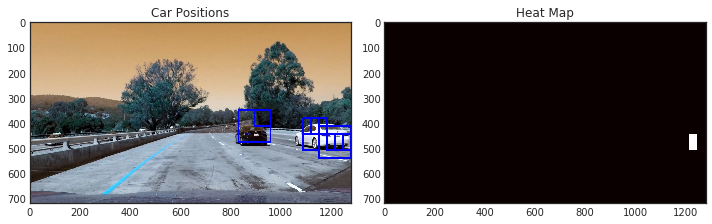

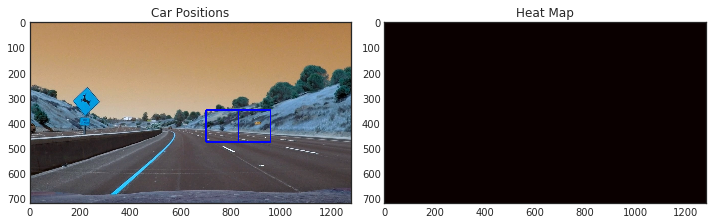

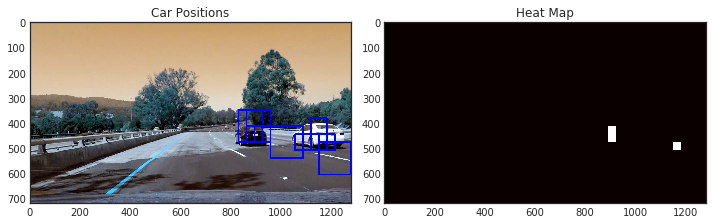

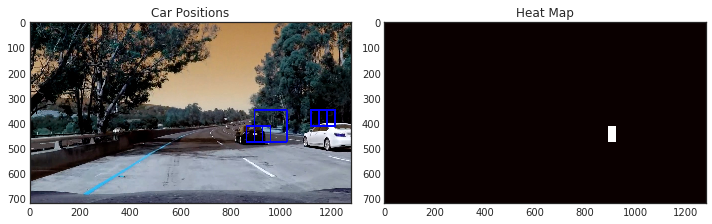

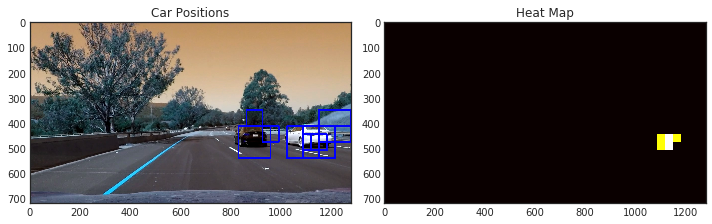

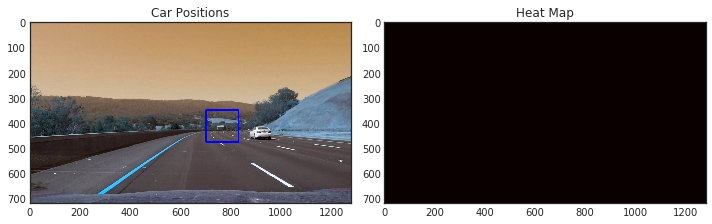

In [26]:
for file in glob.iglob('test_images/*'):
    image = cv2.imread(file)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    xy_window = [(64,64),(128,128)]
    y_start_stop = [[350, 600], [350, None]]

    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.5, 0.5))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])


    hot_windows = search_windows(image, windows_final, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                           

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    with sns.axes_style("white"):
        fig = plt.figure(figsize=(10, 10))
        plt.subplot(121)
        plt.imshow(window_img)
        plt.title('Car Positions')
        plt.subplot(122)
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        fig.tight_layout()

In [30]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label


# Read in image similar to one shown above 

def process_img(image, n_frames=30, threshold=20):
    
    global hot_windows_list
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Read in a pickle file with bboxes saved
    # Each item in the "all_bboxes" list will contain a 
    # list of boxes for one of the images shown above
    xy_window = [(96,96),(128,128)]
    y_start_stop = [[350, 600], [350, None]]

     
    windows_temp = []
    hot_windows_temp =[]
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.5, 0.5))
        windows_temp.append(windows) 
    

    windows_final = sum(windows_temp, [])
    
    hot_windows = search_windows(image, windows_final, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)       

    hot_windows_list.append(hot_windows)
    
    if len(hot_windows_list) <= n_frames:
         hot_windows_final = sum(hot_windows_list, []) # Add windows from all available frames
    
    #Look at last n frames and append all hot windows found
    else: 
        for val in hot_windows_list[(len(hot_windows_list) - n_frames -1) : (len(hot_windows_list)-1)]:
            hot_windows_temp.append(val)
    #Flatten this list
        hot_windows_final = sum(hot_windows_temp, [])
        
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows_final)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    plt.imshow(draw_img)
    return draw_img

[MoviePy] >>>> Building video lane_and_vehicle_output4.mp4
[MoviePy] Writing video lane_and_vehicle_output4.mp4


100%|█████████▉| 1260/1261 [05:48<00:00,  3.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: lane_and_vehicle_output4.mp4 

CPU times: user 5min 44s, sys: 2.68 s, total: 5min 47s
Wall time: 5min 48s


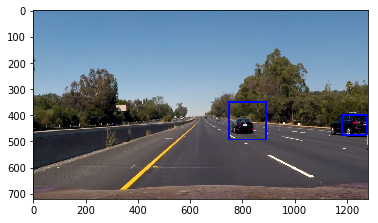

In [31]:
#Create video file pipeline
hot_windows_list = []
from moviepy.editor import VideoFileClip
from IPython.display import HTML
counter=0
output_path = 'lane_and_vehicle_output4.mp4'
clip = VideoFileClip("project_video.mp4")

out_clip = clip.fl_image(process_img) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_path, audio=False)